In [1]:
import pandas as pd
import numpy as np
import liwc
import re
import emoji
from matplotlib import pyplot as plt
from nltk.tokenize import TweetTokenizer
from collections import Counter
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load data and dictionaries
df = pd.read_csv ('data/tweets/IchBinHannaUser.csv')
df= df[['author.description', 'author.id', 'author.name', 'author.public_metrics.followers_count', 'author.public_metrics.following_count', 'author.username', 'author_id', 'created_at', 'id', 'lang', 'public_metrics.retweet_count','text', 'hashtags','reference_type','wanted_tag','user.group']]
german_parse, german_categories = liwc.load_token_parser('data/dicts/LIWC2007_German.dic')
english_parse, english_categories = liwc.load_token_parser('data/dicts/LIWC2015_English.dic')

In [3]:
#prepare data, drop retweets and split it into german and english tweets
#only keep tweets from 01/06/2021 - 30/09/2021
df['new_date'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
df = df.loc[(df['new_date'] > '2021-06-01 00:00:00') & (df['new_date'] <= '2021-09-30 23:59:59')]
df = df.loc[df['reference_type'] != 'retweeted']
df['processed'] = df['text'].replace(r'\\n',  ' ', regex=True)
pat1 = r'@[\w_]+'
pat2 = r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+'
pat3 = r'www.[^ ]+'
combined_pat = r'|'.join((pat1, pat2, pat3))
split_pattern = re.compile(r'\b('  + r')\b')
def tweet_cleaner(demo):
    soup = BeautifulSoup(demo, 'lxml') # HTML
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    return stripped
df['processed'] = [tweet_cleaner(t) for t in df['processed']]
#remove emojis (as seen here: https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2)
def rem_emojis(text):
    emojis = [x for x in text if x in emoji.UNICODE_EMOJI]
    cleaned = ' '.join([str for str in text.split() if not any(i in str for i in emojis)])
    return cleaned
df['processed'] = df['processed'].apply(lambda x: rem_emojis(x))
df['processed'] = df['processed'].apply(lambda x:  re.sub(r'[0-9]+', '', x))
df['processed'] = df['processed'].astype(str)
#tokenize tweets
tweet_tokenizer = TweetTokenizer()
df['tokenized'] = df['processed'].apply(lambda x: tweet_tokenizer.tokenize(x.lower()))
#remove stopwords
nltk.download("stopwords")
german_stop = set(stopwords.words('german'))
english_stop = set(stopwords.words('english'))
df['tokenized'] = df[['tokenized','lang']].apply(lambda x: ' '.join([word for word in x['tokenized'] if word not in (english_stop)]).split() if x['lang'] == 'en' else ' '.join([word for word in x['tokenized'] if word not in (german_stop)]).split(),axis=1)
#remove additional stopwords encountered (like "innen" which occurs because of gendering in german), as well as the hashtag itself, rt etc.
add_stop_all = ["rt", "ichbinhanna", "hanna", "innen", "amp"]
add_stop_ger = ["mehr", "mal", "innen", "ja", "schon"]
add_stop_en = []
df['tokenized'] = df[['tokenized','lang']].apply(lambda x: ' '.join([word for word in x['tokenized'] if word not in (add_stop_all) and word not in  (add_stop_en)]).split() if x['lang'] == 'en' else ' '.join([word for word in x['tokenized'] if word not in (add_stop_all) and word not in  (add_stop_ger)]).split(),axis=1)
#remove all words consisting of only one character (isn'"t", it'"s" etc.)
df['tokenized'] = df['tokenized'].apply(lambda x: [word for word in x if len(word) > 2])
df_ger = df.loc[df['lang'] == "de"]
df_en = df.loc[df['lang'] == "en"]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df_ger['categories'] = df_ger['tokenized'].apply(lambda x: Counter(category for token in x for category in german_parse(token)))
df_en['categories'] = df_en['tokenized'].apply(lambda x: Counter(category for token in x for category in english_parse(token)))

In [5]:
#function to get relative scores of each category
def get_relative(cats, tokens):
    out = {}
    for k in cats:
        out[k] = round(cats[k]/len(tokens),4)
    return out

In [6]:
#convert counter to dict
df_en['categories'] = df_en['categories'].apply(lambda x: dict(x))
df_ger['categories'] = df_ger['categories'].apply(lambda x: dict(x))
#get percentage of classes
df_en['categories'] = [get_relative(x, y) for x, y in zip(df_en['categories'], df_en['tokenized'])]
df_ger['categories'] = [get_relative(x, y) for x, y in zip(df_ger['categories'], df_ger['tokenized'])]
df_ger = df_ger.sort_values(by=['new_date'])

In [7]:
#only keep sentiment information from category-list and align category names from the different dictionarys (Posfeel from the german dictionary is excluded, as all words from this category are also Posemo)
cat_list = ['Posemo', 'Negemo', 'Anx', 'Sad', 'Anger',  'posemo (Positive Emotions)', 'negemo (Negative Emotions)', 'anx (Anx)', 'sad (Sad)', 'anger (Anger)']
def keep_cats(cats):
    out={}
    for k in cats:
        if k in cat_list:
            if k == 'posemo (Positive Emotions)':
                out['Posemo'] = cats[k]
            elif k == 'negemo (Negative Emotions)':
                out['Negemo'] = cats[k]
            elif k == 'anx (Anx)':
                out['Anx'] = cats[k]
            elif k == 'sad (Sad)':
                out['Sad'] = cats[k]
            elif k == 'anger (Anger)':
                out['Anger'] = cats[k]
            else:
                out[k] = cats[k]
    return out

In [8]:
df_en['categories'] = [keep_cats(x) for x in df_en['categories']]
df_ger['categories'] = [keep_cats(x) for x in df_ger['categories']]

In [9]:
#create new columns for each score
df_en[['Posemo', 'Negemo','Anx','Anger', 'Sad']] = df_en['categories'].apply(pd.Series)
df_ger[['Posemo', 'Negemo','Anx','Sad', 'Anger']] = df_ger['categories'].apply(pd.Series)

In [10]:
#make index for the new columns coherent
def df_column_switch(df, column1, column2):
    i = list(df.columns)
    a, b = i.index(column1), i.index(column2)
    i[b], i[a] = i[a], i[b]
    df = df[i]
    return df
df_en = df_column_switch(df_en, 'Sad', 'Anger')

In [11]:
#rejoin data frame, then fill sentiment values with NaN with zeros
df_sentiment = pd.concat([df_en,df_ger])
df_sentiment['Posemo'] = df_sentiment['Posemo'].fillna(0.0)
df_sentiment['Negemo'] = df_sentiment['Negemo'].fillna(0.0)
df_sentiment['Anger'] = df_sentiment['Anger'].fillna(0.0)
df_sentiment['Sad'] = df_sentiment['Sad'].fillna(0.0)
df_sentiment['Anx'] = df_sentiment['Anx'].fillna(0.0)

In [12]:
df_sentiment['Sentiment Score'] = df_sentiment['Posemo'] - df_sentiment['Negemo']

In [13]:
#calculate the ratio of retweets divided by followers to later apply weighting to the sentiment score
df_sentiment['Follow Retweet Ratio'] =df_sentiment['public_metrics.retweet_count']/df_sentiment['author.public_metrics.followers_count']

In [14]:
#determine the threshold to remove users with less followers to not let them dominate the weighting
test = []
for i in df_sentiment['public_metrics.retweet_count'].loc[df_sentiment['author.public_metrics.followers_count'] <= 50]:
    test.append(i)
    
print(max(test))
#set all ratios below threshold to 0
df_sentiment['Follow Retweet Ratio'].loc[df_sentiment['author.public_metrics.followers_count'] < 50] =0

63.0


In [15]:
#normalize score using min max scaling to reduce dominance of weighting
df_sentiment['Follow Retweet Ratio'] =  (df_sentiment['Follow Retweet Ratio'] - df_sentiment['Follow Retweet Ratio'].min()) / (df_sentiment['Follow Retweet Ratio'].max() - df_sentiment['Follow Retweet Ratio'].min()) 

In [16]:
#sentiment score is weighted by adding normalized retweet/follower ratio * initial score to it
df_sentiment['Weighted Score'] = df_sentiment['Sentiment Score'] + df_sentiment['Sentiment Score']*df_sentiment['Follow Retweet Ratio']

In [17]:
conditions = [(df_sentiment['Weighted Score'] < 0), (df_sentiment['Weighted Score'] == 0),(df_sentiment['Weighted Score'] > 0)]
values = ['negative', 'neutral', 'positive']
df_sentiment['sentiment'] = np.select(conditions, values)
print(df_sentiment['sentiment'].value_counts())

neutral     8888
positive    7521
negative    3527
Name: sentiment, dtype: int64


In [18]:
print(df_sentiment['sentiment'].value_counts(normalize=True))

neutral     0.445827
positive    0.377257
negative    0.176916
Name: sentiment, dtype: float64


In [19]:
df_sentiment_de = df_sentiment.loc[df_sentiment['lang']=='de']
df_sentiment_en = df_sentiment.loc[df_sentiment['lang'] == 'en']

In [20]:
#some descriptive statistics
print("Max and Min Sentiment scores:\n Max:{0}\n Min:{1}".format(df_sentiment['Weighted Score'].max(), df_sentiment['Weighted Score'].min()))
print("Mean Sentiment score:\n {0}".format(round(df_sentiment['Weighted Score'].mean(),4)))
print(df_sentiment_de['sentiment'].value_counts())
print(df_sentiment_de['sentiment'].value_counts(normalize=True))
print(df_sentiment_en['sentiment'].value_counts())
print(df_sentiment_en['sentiment'].value_counts(normalize =True))

Max and Min Sentiment scores:
 Max:0.6669593614469935
 Min:-0.6667
Mean Sentiment score:
 0.0249
neutral     7771
positive    6506
negative    3037
Name: sentiment, dtype: int64
neutral     0.448828
positive    0.375765
negative    0.175407
Name: sentiment, dtype: float64
neutral     1117
positive    1015
negative     490
Name: sentiment, dtype: int64
neutral     0.426011
positive    0.387109
negative    0.186880
Name: sentiment, dtype: float64


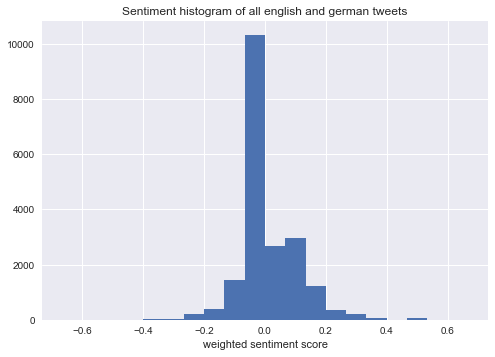

In [21]:
#distribution of overall sentiment scores
plt.style.use('seaborn')
df_sentiment['Weighted Score'].hist(bins =20)
plt.title('Sentiment histogram of all english and german tweets')
plt.xlabel('weighted sentiment score')
plt.savefig('LIWC_sentiment_hist.pdf')
plt.show()

In [22]:
df_day = df_sentiment[['new_date', 'Weighted Score']]
#compute mean scores over days
df_day = df_day.groupby([pd.to_datetime(df_day['new_date']).dt.date]).mean()
df_day = df_day.reset_index()

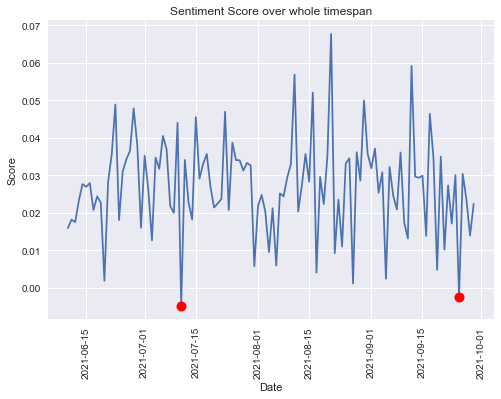

In [23]:
plt.plot(df_day['new_date'],df_day['Weighted Score'])
plt.title('Sentiment Score over whole timespan')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.plot(pd.to_datetime('2021-09-25'), -0.002382, marker='o', markersize=10, color="red")
plt.plot(pd.to_datetime('2021-07-11'), -0.004781, marker='o', markersize=10, color="red")
plt.savefig('LIWC_full_sentiment.pdf')
plt.show()

In [24]:
df_day.loc[df_day['Weighted Score'] == min(df_day['Weighted Score'])]

,new_date,Weighted Score
31,2021-07-11,-0.004781


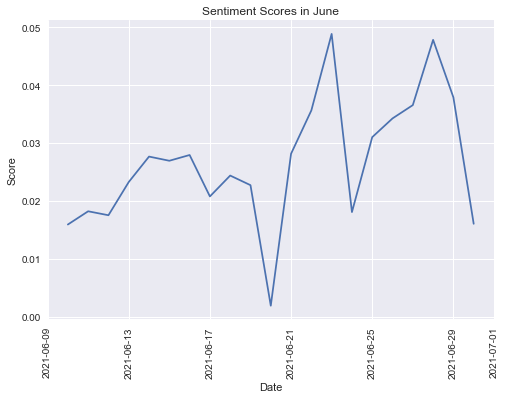

In [25]:
#for a better overview, split the data into months
df_june = df_day.loc[df_day['new_date'] < pd.to_datetime('2021-07-01')]
plt.plot(df_june['new_date'],df_june['Weighted Score'])
plt.title('Sentiment Scores in June')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.show()

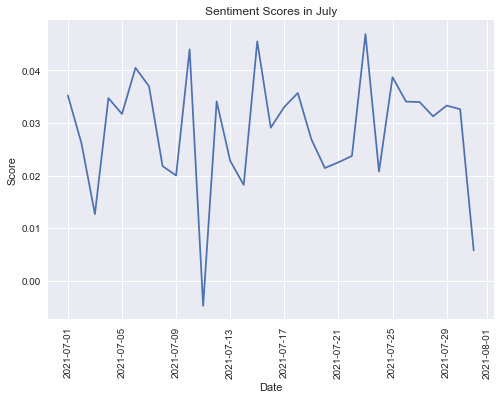

In [26]:
df_july = df_day.loc[(df_day['new_date'] > pd.to_datetime('2021-06-30')) & (df_day['new_date'] < pd.to_datetime('2021-08-01'))]
plt.plot(df_july['new_date'],df_july['Weighted Score'])
plt.title('Sentiment Scores in July')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.show()

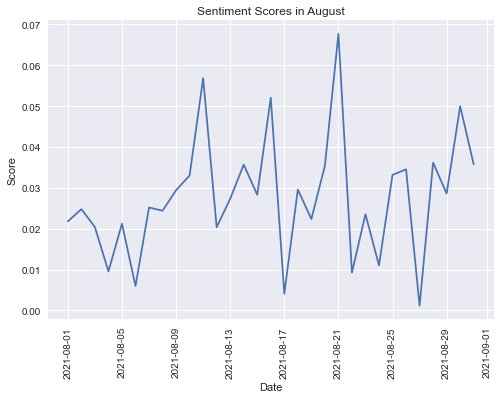

In [27]:
df_august = df_day.loc[(df_day['new_date'] > pd.to_datetime('2021-07-31')) & (df_day['new_date'] < pd.to_datetime('2021-09-01'))]
plt.plot(df_august['new_date'],df_august['Weighted Score'])
plt.title('Sentiment Scores in August')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.show()

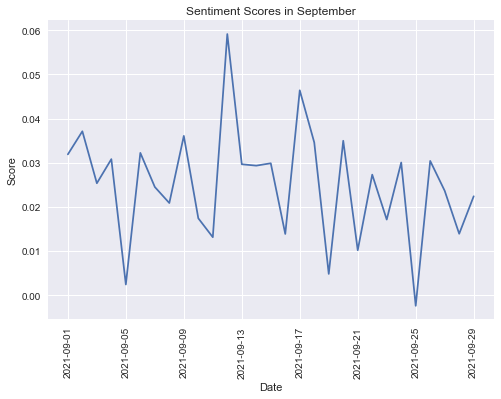

In [28]:
df_september = df_day.loc[(df_day['new_date'] > pd.to_datetime('2021-08-31')) & (df_day['new_date'] < pd.to_datetime('2021-10-01'))]
plt.plot(df_september['new_date'],df_september['Weighted Score'])
plt.title('Sentiment Scores in September')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.show()

In [29]:
pos_LIWC = df_sentiment.loc[df_sentiment['sentiment'] == 'positive']
neg_LIWC = df_sentiment.loc[df_sentiment['sentiment'] == 'negative']
pos_LIWC = pos_LIWC['text']
neg_LIWC = neg_LIWC['text']

In [30]:
#for further investigation
compression_opts = dict(method='zip',
                        archive_name='pos_LIWC.csv')  
pos_LIWC.to_csv('out.zip', index=False,
          compression=compression_opts) 

In [31]:
#for further investigation
compression_opts = dict(method='zip',
                        archive_name='neg_LIWC.csv')  
neg_LIWC.to_csv('out.zip', index=False,
          compression=compression_opts) 

## Agreement of LIWC and VADER

In [32]:
vader_sentiment = pd.read_csv ('data/tweets/vader_sentiment.csv', index_col=0)

In [33]:
print(len(vader_sentiment))
print(len(df_sentiment))

19936
19936


In [34]:
vader_sentiment = vader_sentiment.sort_values(by = ['new_date'])
df_sentiment = df_sentiment.sort_values(by=['new_date'])

In [35]:
vader_sent = vader_sentiment['sentiment']
df_sentiment['vader sentiment'] = vader_sent
total_agreement = np.where(df_sentiment['sentiment'] == df_sentiment['vader sentiment'])
df_pos_ag = df_sentiment.loc[df_sentiment['sentiment'] == 'positive']
positive_agreement = np.where(df_pos_ag['sentiment'] == df_pos_ag['vader sentiment'])
df_neg_ag = df_sentiment.loc[df_sentiment['sentiment'] == 'negative']
negative_agreement = np.where(df_neg_ag['sentiment'] == df_neg_ag['vader sentiment'])
df_neu_ag = df_sentiment.loc[df_sentiment['sentiment'] == 'neutral']
neutral_agreement = np.where(df_neu_ag['sentiment'] == df_neu_ag['vader sentiment'])

In [36]:
print('Total agreement: {0} \nRelative: {1}'.format(len(total_agreement[0]), len(total_agreement[0])/len(df_sentiment)))
print('Positive agreement: {0} \nRelative: {1}'.format(len(positive_agreement[0]), len(positive_agreement[0])/len(df_pos_ag)))
print('Negative agreement: {0} \nRelative: {1}'.format(len(negative_agreement[0]), len(negative_agreement[0])/len(df_neg_ag)))
print('Neutral agreement: {0} \nRelative: {1}'.format(len(neutral_agreement[0]), len(neutral_agreement[0])/len(df_neu_ag)))

Total agreement: 11417 
Relative: 0.5726825842696629
Positive agreement: 6141 
Relative: 0.8165137614678899
Negative agreement: 1981 
Relative: 0.5616671392117947
Neutral agreement: 3295 
Relative: 0.3707245724572457


In [37]:
#change threshold for neutral tweets to -0.1 - 0.1 (for LIWC)
conditions = [(df_sentiment['Weighted Score'] <= -0.1), (-0.1 < df_sentiment['Weighted Score'])&(df_sentiment['Weighted Score'] < 0.1),(df_sentiment['Weighted Score'] >= 0.1)]
values = ['negative', 'neutral', 'positive']
df_sentiment['thresholded sentiment'] = np.select(conditions, values)
print(df_sentiment['thresholded sentiment'].value_counts())
total_agreement = np.where(df_sentiment['thresholded sentiment'] == df_sentiment['vader sentiment'])
df_pos_ag = df_sentiment.loc[df_sentiment['thresholded sentiment'] == 'positive']
positive_agreement = np.where(df_pos_ag['thresholded sentiment'] == df_pos_ag['vader sentiment'])
df_neg_ag = df_sentiment.loc[df_sentiment['thresholded sentiment'] == 'negative']
negative_agreement = np.where(df_neg_ag['thresholded sentiment'] == df_neg_ag['vader sentiment'])
df_neu_ag = df_sentiment.loc[df_sentiment['thresholded sentiment'] == 'neutral']
neutral_agreement = np.where(df_neu_ag['thresholded sentiment'] == df_neu_ag['vader sentiment'])
print('Total agreement: {0} \nRelative: {1}'.format(len(total_agreement[0]), len(total_agreement[0])/len(df_sentiment)))
print('Positive agreement: {0} \nRelative: {1}'.format(len(positive_agreement[0]), len(positive_agreement[0])/len(df_pos_ag)))
print('Negative agreement: {0} \nRelative: {1}'.format(len(negative_agreement[0]), len(negative_agreement[0])/len(df_neg_ag)))
print('Neutral agreement: {0} \nRelative: {1}'.format(len(neutral_agreement[0]), len(neutral_agreement[0])/len(df_neu_ag)))

neutral     15100
positive     3513
negative     1323
Name: thresholded sentiment, dtype: int64
Total agreement: 7641 
Relative: 0.38327648475120385
Positive agreement: 3002 
Relative: 0.8545402789638485
Negative agreement: 836 
Relative: 0.6318972033257747
Neutral agreement: 3803 
Relative: 0.2518543046357616


In [38]:
#report cohens kappa as inter annotator agreement
cohen_kappa_score(df_sentiment.sentiment, df_sentiment['vader sentiment'])

0.34532051384450635

In [39]:
confusion_matrix(df_sentiment.sentiment, df_sentiment['vader sentiment'])

array([[1981,  311, 1235],
       [1634, 3295, 3959],
       [ 800,  580, 6141]], dtype=int64)

In [40]:
from sklearn.metrics import classification_report
classif_report = classification_report( df_sentiment['vader sentiment'],df_sentiment.sentiment, output_dict=True)
classif_report = pd.DataFrame(classif_report).transpose()
classif_report

,precision,recall,f1-score,support
negative,0.561667,0.448698,0.498867,4415.000000
neutral,0.370725,0.787148,0.504054,4186.000000
positive,0.816514,0.541773,0.651358,11335.000000
accuracy,0.572683,0.572683,0.572683,0.572683
macro avg,0.582968,0.592540,0.551426,19936.000000
weighted avg,0.666473,0.572683,0.586658,19936.000000


## Sentiment per user group

In [41]:
user_sent = df_sentiment.groupby(by=['user.group'])['Sentiment Score'].mean()
user_sent

user.group
Academic unspecified    0.031303
Bot                     0.037067
Institution             0.031269
Jun. prof               0.022160
Media                   0.016378
Medical doctor          0.000000
Political rep           0.032970
Postdoc                 0.027303
Prof                    0.025970
Promovierende           0.028567
Student                 0.022893
Teacher                 0.016993
Union rep               0.017640
Name: Sentiment Score, dtype: float64

In [42]:
df_sentiment['user.group'].value_counts()

Postdoc                 5506
Academic unspecified    3692
Promovierende           1249
Prof                    1235
Media                    401
Union rep                312
Institution              265
Student                  241
Political rep            141
Jun. prof                 90
Bot                       60
Teacher                   28
Medical doctor             1
Name: user.group, dtype: int64

In [43]:
test =df_sentiment['user.group'].value_counts()